<a href="https://colab.research.google.com/github/RoginRobert2014/CE888/blob/main/Lab_8/transfer_learning_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Location to read the training dataset    
data_directory = "/content/drive/MyDrive/Colab Notebooks/CE888/labs/lab8/data"

In [4]:
# Selecting the batch_size and image_dimension
batch_size_count = 16
image_height = 224
image_width = 224

In [11]:
# Reading the training dataset
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.70, 
    subset="training",
    seed=1337,
    image_size=(image_height, image_width),
    batch_size=batch_size_count)

Found 808 files belonging to 4 classes.
Using 243 files for training.


In [13]:
# Reading the validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.10,
    subset="validation",
    seed=1337,
    image_size=(image_height, image_width),
    batch_size=batch_size_count)

Found 808 files belonging to 4 classes.
Using 80 files for validation.


In [14]:
# Print the list of categories of images
class_list = training_dataset.class_names
print(class_list)

['Humans', 'cats', 'dogs', 'horses']


In [15]:
image_input = Input(shape=(image_height, image_width, 3))

In [17]:
# Creating the transfer model using ResNet101 pretrainied model

transfer_model = tf.keras.applications.resnet.ResNet101(include_top=True,
    weights="imagenet",
    input_tensor=image_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")

179650560/179648224 [==============================] - 1s 0us/step


In [18]:
# Display the  summary of VGG16 model
transfer_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [19]:
last_layer = transfer_model.get_layer('predictions').output
out = Dense(4, activation='sigmoid', name='output')(last_layer)  ## 4 classes
new_model = Model(image_input, out)

for layer in new_model.layers[:-1]:
	layer.trainable = False

new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
# Display the  summary of new model
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [24]:
new_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['acc'])

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/CE888/labs/lab8/weights/resnet.h5', save_best_only=True),
]

In [26]:
# Fitting the model with train data and validating with validation data
history = new_model.fit(
    training_dataset,
    epochs=2,
    validation_data=validation_dataset,
    callbacks=[my_callbacks]
    ) 

Epoch 1/2
16/16 [==============================] - 294s 13s/step - loss: 1.3855 - acc: 0.2845 - val_loss: 1.3772 - val_acc: 0.3875
Epoch 2/2
16/16 [==============================] - 93s 6s/step - loss: 1.3742 - acc: 0.5316 - val_loss: 1.3676 - val_acc: 0.5125


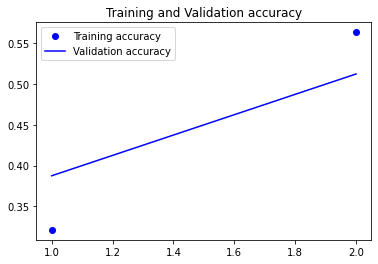

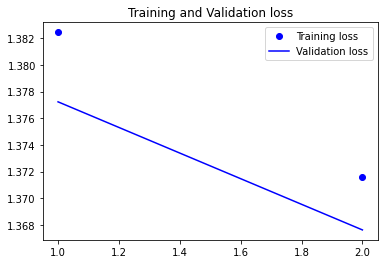

In [30]:
# Visualize the results
training_acc = history.history['acc']
validation_acc = history.history['val_acc']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_acc) + 1)

plt.plot(epochs, training_acc, 'bo', label='Training accuracy')
plt.plot(epochs, validation_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [32]:
# Load the trainied model
trained_model = load_model('/content/drive/MyDrive/Colab Notebooks/CE888/labs/lab8/weights/resnet.h5')

In [33]:
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [34]:
# Reading the test dataset
testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.20,
    subset="validation",
    seed=1337,
    image_size=(image_height, image_width),
    batch_size=batch_size_count)

Found 808 files belonging to 4 classes.
Using 161 files for validation.


In [35]:
testing_dataset.class_names

['Humans', 'cats', 'dogs', 'horses']

In [36]:
predictions = trained_model.predict(testing_dataset,steps=len(testing_dataset), verbose=0)

In [37]:
predictions

array([[0.49113753, 0.49610108, 0.48940605, 0.49266165],
       [0.50689554, 0.49581298, 0.5000664 , 0.48804715],
       [0.50648445, 0.4823722 , 0.50689524, 0.50721925],
       [0.5029707 , 0.49605763, 0.4868856 , 0.5011524 ],
       [0.51087236, 0.4899876 , 0.49233   , 0.49741593],
       [0.50041133, 0.49262297, 0.49347392, 0.5001806 ],
       [0.49857008, 0.49413645, 0.49371278, 0.49668026],
       [0.51065373, 0.48447436, 0.49533114, 0.49993882],
       [0.4942483 , 0.48732513, 0.5105243 , 0.5103952 ],
       [0.5001335 , 0.49048167, 0.50257355, 0.49816254],
       [0.49298742, 0.48860312, 0.5008866 , 0.50347275],
       [0.49369392, 0.49704823, 0.48986155, 0.49421567],
       [0.5057625 , 0.49578115, 0.49842644, 0.5029929 ],
       [0.49928874, 0.4952531 , 0.50449806, 0.49457842],
       [0.5010322 , 0.4981931 , 0.4952939 , 0.49624878],
       [0.4955865 , 0.5000665 , 0.4916724 , 0.5009735 ],
       [0.5156848 , 0.48176184, 0.48438007, 0.51871884],
       [0.4990577 , 0.49186766,